In [2]:
from typing import Type, List
import math
import cmath

import matplotlib.pyplot as plt
import numpy as np

In [12]:
def cuberoot(x: np.complex128) -> List[Type[np.complex128]]:
    """
    Вычисление кубического корня
    """
    cuberoots_of_1 = 1, (-0.5 + 0.8660254j), (-0.5 - 0.8660254j)
    cr = complex(x) ** (1 / 3)
    return [cr * cr1 for cr1 in cuberoots_of_1]

In [3]:
def upper_lower_bound(poly1d: Type[np.poly1d]) -> List[float]:
    """
    Поиск нижней и верхней границы значений корней по модулю
    https://en.wikipedia.org/wiki/Geometrical_properties_of_polynomial_roots
    """
    degree = len(poly1d)
    upper = 1 + max(abs(poly1d[x] / poly1d[degree]) for x in range(degree - 1))
    lower = abs(poly1d[degree]) / (abs(poly1d[degree]) + max(abs(poly1d[x]) for x in range(1, degree)))
    return [upper, lower]

In [5]:
def draw(
    poly1d: Type[np.poly1d],
    roots: List[Type[np.complex128]],
    points_amount: int = 10000,
):
    """
    Отрисовка полинома и его корней
    """
    a = min(roots)
    b = max(roots)
    if a == b:
        a -= 10
        b += 10
    else:
        offset = (b - a) / 50
        a -= offset
        b += offset
        a = a.real
        b = b.real

    x = list(np.arange(a, b, (b - a) / points_amount))
    y = [poly1d(el) for el in x]
    plt.plot(x, y, c="#006400")

    x = [root for root in roots if round(root.imag, 14) == 0]
    y = [poly1d(el) for el in x]
    plt.scatter(x, y, c=["#8B0000" for _ in x], marker="o")

    plt.grid()
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 8
    plt.rcParams["figure.figsize"] = fig_size

In [6]:
def solve_2(poly1d: Type[np.poly1d]) -> List[Type[np.complex128]]:
    """
    Поиск корней для полинома 2 степени.
    Решение квадратных уравнений.
    """
    a = poly1d[2]
    b = poly1d[1]
    c = poly1d[0]
    d = b**2 - 4 * a * c
    if d == 0:
        x = round((-b - math.sqrt(d)) / (2 * a), accuracy)
        return [x]
    else:
        x_1 = (-b - cmath.sqrt(d)) / (2 * a)
        x_2 = (-b + cmath.sqrt(d)) / (2 * a)
        return [x_1, x_2]

In [7]:
def solve_3(poly1d: Type[np.poly1d]) -> List[Type[np.complex128]]:
    """
    Поиск корней для полинома 3 степени.
    Используется метод виета для решения данного полинома
    https://en.wikipedia.org/wiki/Cubic_equation#Vieta's_substitution
    """
    a = poly1d[3]
    b = poly1d[2]
    c = poly1d[1]
    d = poly1d[0]
    q = (2 * b**3 - 9 * a * b * c + 27 * a**2 * d) / (27 * a**3)
    p = (3 * a * c - b**2) / (3 * a**2)
    t = np.poly1d([1, q, -(p**3) / 27])
    W = solve_2(t)
    w_1, w_2, w_3 = cuberoot(-W[0])
    t_1 = w_1 - p / (3 * w_1)
    t_2 = w_2 - p / (3 * w_2)
    t_3 = w_3 - p / (3 * w_3)
    x_3 = -(t_1 + (b / (3 * a)))
    x_2 = -(t_2 + (b / (3 * a)))
    x_1 = -(t_3 + (b / (3 * a)))
    return [x_1, x_2, x_3]

In [8]:
def solve_4(poly1d: Type[np.poly1d]) -> List[Type[np.complex128]]:
    """
    Поиск корней для полинома 4 степени.
    Решение через метод Феррари
    https://www.resolventa.ru/spr/algebra/ferrary.htm
    """
    a_0 = poly1d[4]
    a = poly1d[3] / a_0
    b = poly1d[2] / a_0
    c = poly1d[1] / a_0
    d = poly1d[0] / a_0
    p = b - (3 * a**2 / 8)
    q = a**3 / 8 - (a * b / 2) + c
    r = -3 * a**4 / 256 + a**2 * b / 16 - c * a / 4 + d
    S = np.poly1d([2, -p, -2 * r, r * p - (q**2 / 4)])
    s = solve_3(S)[1]
    y_1, y_2 = solve_2(np.poly1d([1, -cmath.sqrt(2 * s - p), s + q / (2 * (cmath.sqrt(2 * s - p)))]))
    y_3, y_4 = solve_2(np.poly1d([1, cmath.sqrt(2 * s - p), s - q / (2 * (cmath.sqrt(2 * s - p)))]))
    x_1 = y_1 - a / 4
    x_2 = y_2 - a / 4
    x_3 = y_3 - a / 4
    x_4 = y_4 - a / 4
    return [x_1, x_2, x_3, x_4]

In [9]:
def solve_n(poly1d: Type[np.poly1d]) -> List[Type[np.complex128]]:
    """
    Поиск корней для полинома любой степени.
    Метод Аберта
    https://en.wikipedia.org/wiki/Aberth_method
    """

    # Init roots
    degree = len(poly1d)
    upper, lower = upper_lower_bound(poly1d)
    roots = []
    for i in range(degree):
        radius = np.random.uniform(lower, upper)
        angle = np.random.uniform(0, math.pi * 2)
        root = np.complex128(complex(radius * math.cos(angle), radius * math.sin(angle)))
        roots.append(root)
    #
    valid_root = [False for _ in roots]
    while sum(valid_root) < len(roots):
        for idx, z in enumerate(roots):
            if not valid_root[idx]:
                ratio = poly1d(z) / poly1d.deriv()(z)
                offset = ratio / (1 - ratio * sum((1 / (z - z_j)) for jdx, z_j in enumerate(roots) if jdx != idx))
                roots[idx] -= offset
                if abs(np.round(offset, 14)) == 0:
                    valid_root[idx] = True
    return roots

Степень полинома: 5
Полином:
    5     4            3
7 x + 6 x + (5 + 1j) x + 99 x + (-3213 + 234j) = 0

Количество корней:
4 (5 - комлексных, 0 - действительный)

Корни:
(-2.9528526015-2.0440893347j)
(-2.9131983469+2.1369329434j)
(0.8893112431-3.2410395906j)
(0.9716993479+3.2080476869j)
(3.1478975003-0.059851705j)

Проверка встроенным в numpy поиском корней:
(-2.9528526015-2.0440893347j)
(-2.9131983469+2.1369329434j)
(0.8893112431-3.2410395906j)
(0.9716993479+3.2080476869j)
(3.1478975003-0.059851705j)

Ответы сходятся: Да

Проверим значение в найденных точках:
(-0+0j)
(-0-0j)
-0j
(-0-0j)
(-0+0j)


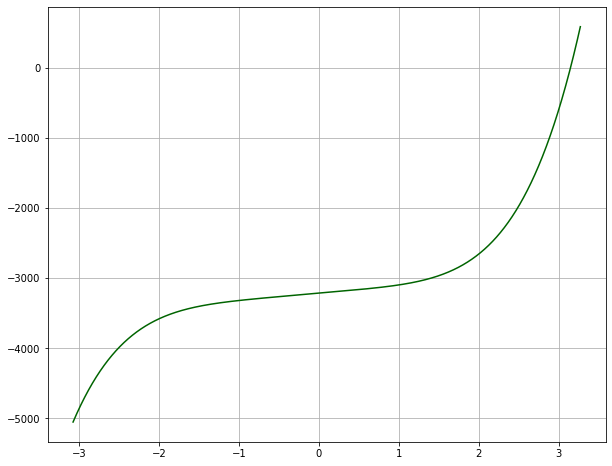

In [12]:
def main(
    poly1d: Type[np.poly1d],
    accuracy: int = 100,
    q: bool = False,
    should_draw: bool = False,
):
    """
    Основной метод для решения полинома
    """
    if not q:
        print("Степень полинома:", len(poly1d))
        print("Полином:\n", poly1d, "= 0")
    # len(poly1d) -
    if len(poly1d) >= 5:
        X = solve_n(poly1d)
    elif len(poly1d) == 4:
        X = solve_4(poly1d)
    elif len(poly1d) == 3:
        X = solve_3(poly1d)
    elif len(poly1d) == 2:
        X = solve_2(poly1d)
    elif len(poly1d) == 1:
        X = [-poly1d[0] / poly1d[1]]
    if len(poly1d) == 0:
        X = []
        if poly1d[0] == 0:
            if not q:
                print("X принажлежит всем действительным числам")
        else:
            if not q:
                print("Пустое множество")
        return []
    else:
        X_accuracy = list(map(lambda x: np.round(x, accuracy), X))
        X_accuracy.sort()
        X.sort()
        if not q:
            sum_comp = sum(np.iscomplex(X))
            real_ans = list(map(lambda x: np.round(x, accuracy), poly1d.r))
            real_ans.sort()
            print(f"\nКоличество корней:\n4 ({sum_comp} - комлексных, {len(poly1d)-sum_comp} - действительный)\n")
            print("Корни:")
            print(*X_accuracy, sep="\n")
            print("\nПроверка встроенным в numpy поиском корней:")
            print(*real_ans, sep="\n")
            print("\nОтветы сходятся:", "Да" if X_accuracy == real_ans else "Нет")
            print(
                "\nПроверим значение в найденных точках:\n"
                f"{chr(10).join(map(lambda x: str(np.round(poly1d(x), accuracy)), X))}"
            )
        if should_draw:
            draw(poly1d, X)
        return X_accuracy


main(np.poly1d([7, 6, 5 + 1j, 0, 99, -3213 + 234j]), 10, should_draw=True);

In [102]:
def test_main(
    poly_size: int,
    testing_size: int,
    a: float,
    b: float,
    accuracy: int = 5,
    complex_: bool = False,
    show: bool = False,
) -> None:
    """
    Метод для тестирования на корректность ответа
    """
    failled = []
    for idx in range(testing_size):
        if complex_:
            poly1d = np.poly1d(
                list(
                    map(
                        lambda x: complex(np.random.uniform(a, b), np.random.uniform(a, b)),
                        range(poly_size),
                    )
                )
            )
        else:
            poly1d = np.poly1d(list(map(lambda x: np.random.uniform(a, b), range(poly_size))))
        ans_main = main(poly1d, accuracy, q=True)
        ans_np = sorted(list(map(lambda x: np.round(x, accuracy), poly1d.r)))
        # print(ans_main, ans_np)
        if ans_main != ans_np:
            failled.append([poly1d, ans_main, ans_np])
        if show:
            print(f"Test {idx}\n" f"{poly1d}\n" f"main:\t{ans_main}\n" f"np:\t{ans_np}\n")
    if failled:
        print(f"Test failled {len(failled)}/{testing_size}")
        for idx, fail in enumerate(failled):
            print(f"Fail {idx}\n" f"{fail[0]}\n" f"main:\t{fail[1]}\n" f"np:\t{fail[2]}\n")
    else:
        print("All tests passed")


test_main(6, 100, -1000, 1000, 5, complex_=True)

All tests passed
